# Price Simulation

We have a few ways for generating prices.

### Collateral Prices

We simulate collateral prices (e.g. WETH) as correlated GBMs. We estimate the generative GBM parameters using historical data from Coingecko (see `scripts/gen_price_config.py`).

### Stablecoin Prices

We simulate stablecoin prices (e.g. USDC) as correlated Ornstein-Uhlenbeck (OU) processes. These are simply mean-reverting GBMs. We similarly estimate the generative OU parameters using a Maximum Likelihood Estimator (MLE) on historical Coingecko data (see `src/prices/utils.py`).

## Shocks

We apply three kinds of shocks in different scenarios:

1. Drift-shock: we may shock the drift parameter of the collateral GBMs. This allows us to control the expected returns per-timestep. For example, the baseline scenarios will shock the drift by setting it to 0. See `src/sim/scenarios/baseline/__init__.py`.
2. Volatility-shock: we may shock the volatility parameter of the collateral or stablecoin processes. This allows us to enforce higher price volatility in our simulations.
3. Jumps.

We will dive deeper into jumps in this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.sim.scenario import Scenario
from src.prices.utils import get_factor
from datetime import datetime
import pandas as pd
import requests as req
from src.plotting.utils import make_square
from src.sim.strategies import STRATEGIES
from src.metrics import DEFAULT_METRICS
from src.configs.tokens import WBTC

plt.rcParams["axes.spines.right"] = True

# Estimating Stressed Drift and Volatility

Our stress scenarios consider stressed drift and volatility parameters for simulating collateral prices. We calculate the stress variables as follows:

### Stressed Volatility

We take the p99 standard deviation of log returns. 

More specifically, we fetch hourly price data from Jan20 to Jan24. We resample this data at the simulation frequency (5min). We then compute the log returns of our data. From these 5min log returns, we compute the intraday volatility for the asset as the standard deviation of log returns in a 1 day rolling window.

We assume that wstETH and sfrxETH have similar stressed volatilities to ETH (we have much more data on ETH price volatility!)

In [254]:
# Fetch prices from cryptocompare (more granular than CoinGecko)
url = "https://min-api.cryptocompare.com/data/v2/histohour"
params = {
    "tsym": "USD",
    "limit": 2000,
}


def fetch(sym, end=None):
    if end:
        params["toTs"] = end
    params["fsym"] = sym
    res = req.get(url, params=params)
    data = res.json()["Data"]
    start = data["TimeFrom"]
    df = pd.DataFrame(data["Data"])
    df.set_index(pd.to_datetime(df["time"], unit="s"), inplace=True)
    df = df["close"]
    return df, start


def fetch_all(sym, start, freq):
    dfs = []
    ts = datetime.now().timestamp()
    while ts > start:
        df, ts = fetch(sym, ts)
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_index(inplace=True)
    df = df.resample(freq).last().ffill()
    return pd.DataFrame(df)


def get_rolling_std(df, freq, window):
    annual_factor = get_factor(freq)
    col = "close"  # TODO should be ticker
    df[f"{col}_returns"] = df[col].pct_change()
    df[f"{col}_log_returns"] = np.log1p(df[f"{col}_returns"])
    rolling_std = df[f"{col}_log_returns"].rolling(window).std() * np.sqrt(
        annual_factor
    )
    return rolling_std


def calc_stressed_volatilites(syms, start, freq, window, plot=False):
    """
    Calculate the stressed volatilities for the input coins.
    Optionally plot.
    """
    stats = []

    if plot:
        n, m = make_square(len(syms))
        f, axs = plt.subplots(n, m, figsize=(10, 5))

    for i, sym in enumerate(syms):
        # Fetch and process data
        df = fetch_all(sym, start, freq)
        rolling_std = get_rolling_std(df, freq, window)
        stats.append(
            {
                "symbol": sym,
                "mean": rolling_std.mean(),
                "median": rolling_std.quantile(0.5),
                "p99": rolling_std.quantile(0.99),
            }
        )

        if plot:
            if n == 1 and m == 1:
                ax = axs
            elif n == 1:
                ax = axs[i]
            else:
                ax = axs[i // m, i % m]

            ax2 = ax.twinx()
            ax.plot(df.index, df["close"], color="black", label="Hourly Price")
            ax.set_ylabel("Price")
            ax2.plot(
                rolling_std.index,
                rolling_std,
                color="indianred",
                label="Intraday Volatility",
            )
            ax2.set_ylabel("Volatility")
            ax.tick_params(axis="x", rotation=45)
            ax.set_title(f"{sym} Price vs Intraday Volatility")

    if plot:
        f.tight_layout()
        plt.show()

    stats = pd.DataFrame(stats)
    stats.set_index("symbol", inplace=True)
    return stats

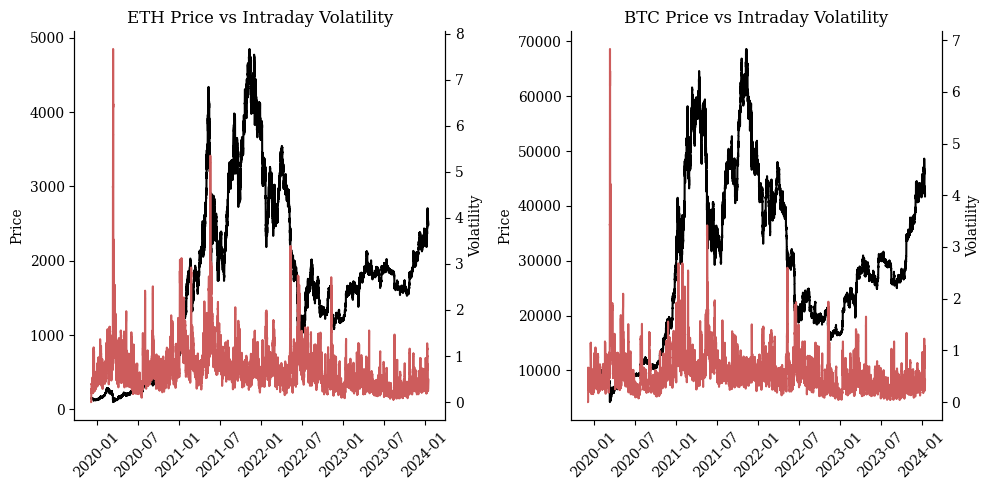

,mean,median,p99
symbol,,,
ETH,0.717561,0.620905,2.445831
BTC,0.560364,0.484379,1.877968


In [255]:
freq = "5min"
window = "1d"
start = int(datetime(2020, 1, 1).timestamp())
stats = calc_stressed_volatilites(["ETH", "BTC"], start, freq, window, plot=True)
stats

## Plotting the difference in prices

Does scaling volatility lead to meaningfully different prices?

In [2]:
markets = ["wsteth", "weth", "wbtc", "sfrxeth"]

baseline = Scenario("baseline_micro", markets)
highvol = Scenario("high_volatility", markets)

[INFO][20:50:05][src.sim.scenario]-13322: Fetching wsteth market from subgraph
[INFO][20:50:08][src.sim.scenario]-13322: Market snapshot as 2024-01-14 20:16:23
[INFO][20:50:08][src.sim.scenario]-13322: Bands snapshot as 2024-01-14 19:02:47
[INFO][20:50:08][src.sim.scenario]-13322: Users snapshot as 2024-01-14 15:05:47
[INFO][20:50:08][src.sim.scenario]-13322: Fetching weth market from subgraph
[INFO][20:50:11][src.sim.scenario]-13322: Market snapshot as 2024-01-14 20:16:23
[INFO][20:50:11][src.sim.scenario]-13322: Bands snapshot as 2024-01-14 19:02:47
[INFO][20:50:11][src.sim.scenario]-13322: Users snapshot as 2024-01-14 15:05:47
[INFO][20:50:11][src.sim.scenario]-13322: Fetching wbtc market from subgraph
[INFO][20:50:14][src.sim.scenario]-13322: Market snapshot as 2024-01-14 20:16:23
[INFO][20:50:14][src.sim.scenario]-13322: Bands snapshot as 2024-01-14 19:02:47
[INFO][20:50:14][src.sim.scenario]-13322: Users snapshot as 2024-01-14 15:05:47
[INFO][20:50:14][src.sim.scenario]-13322: Fe

In [10]:
baseline_strat = STRATEGIES["baseline_micro"](DEFAULT_METRICS)
baseline_strat.apply_shocks(baseline)
highvol_strat = STRATEGIES["high_volatility"](DEFAULT_METRICS)
highvol_strat.apply_shocks(highvol)

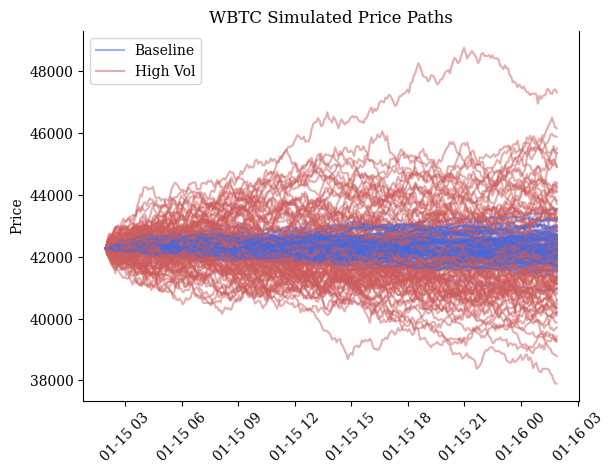

In [24]:
f, ax = plt.subplots()

for i in range(100):
    baseline.generate_pricepaths()
    highvol.generate_pricepaths()
    baseline_label = highvol_label = None
    if i == 0:
        baseline_label = "Baseline"
        highvol_label = "High Vol"
    ax.plot(
        baseline.pricepaths.prices[WBTC],
        color="royalblue",
        alpha=0.5,
        label=baseline_label,
    )
    ax.plot(
        highvol.pricepaths.prices[WBTC],
        color="indianred",
        alpha=0.5,
        label=highvol_label,
    )

ax.legend()
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel("Price")
ax.set_title("WBTC Simulated Price Paths")
print()

# Jumps

In [ ]:
def merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths):
    size = (steps, Npaths)
    dt = T / steps
    poi_rv = np.multiply(
        np.random.poisson(lam * dt, size=size), np.random.normal(m, v, size=size)
    ).cumsum(axis=0)
    geo = np.cumsum(
        (
            (r - sigma**2 / 2 - lam * (m + v**2 * 0.5)) * dt
            + sigma * np.sqrt(dt) * np.random.normal(size=size)
        ),
        axis=0,
    )

    return np.exp(geo + poi_rv) * S


def simple_gbm(S, T, mu, sigma, steps, Npaths):
    size = (steps, Npaths)
    dt = T / steps
    geo = np.cumsum(
        (
            (mu - sigma**2 / 2) * dt
            + sigma * np.sqrt(dt) * np.random.normal(size=size)
        ),
        axis=0,
    )

    return np.exp(geo) * S


S = 100  # current stock price
T = 1  # time to maturity
r = 0.02  # risk free rate
m = 0  # mean of jump size
v = 0.3  # standard deviation of jump
lam = 0  # intensity of jump i.e. number of jumps per annum
steps = 10000  # time steps
Npaths = 10  # number of paths to simulate
sigma = 0.2  # annaul standard deviation , for weiner process

# j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)
j = simple_gbm(S, T, r, sigma, steps, Npaths)

plt.plot(j)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Jump Diffusion Process")